In [26]:
import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()

So... I've already worked with MNIST. But now I want to refresh it and write code by myself. <br>
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/VAE_Basic.png/425px-VAE_Basic.png'>

In [27]:
from keras.datasets.fashion_mnist import load_data

In [28]:
(X_train, _), (X_test, _) = load_data()

In [29]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [30]:
import matplotlib.pyplot as plt

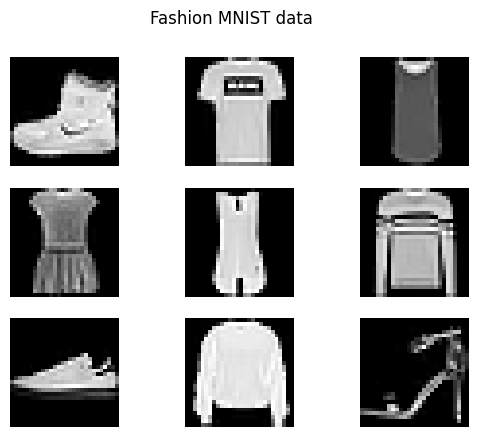

In [31]:
plt.suptitle('Fashion MNIST data')
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.axis('off')
  plt.imshow(X_train[i], cmap='gray');

In [32]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [33]:
X_train.max()

1.0

In [34]:
img_size = X_train.shape[1:]
latent_dims = 3

In [35]:
X_train = X_train.reshape(X_train.shape[0], img_size[0], img_size[1], 1)
X_test = X_test.reshape(X_test.shape[0], img_size[0], img_size[1], 1)

In [36]:
from tensorflow.keras import layers
from tensorflow.keras import Model, Input
import tensorflow.keras.backend as K
from tensorflow import keras

I've made special paper with VAE scheme and info
It'll be on github in this very repository<br>


In [37]:
# encoder part

image_input = Input(shape=img_size + (1,))

x = layers.Conv2D(14, 3, padding='same', activation='relu')(image_input)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

conv_shape = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

In [38]:
def sample_z(args):
  # building distribution
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

In [39]:
# latent dimension

z_mu = layers.Dense(latent_dims)(x)
z_sigma = layers.Dense(latent_dims)(x)
z = layers.Lambda(sample_z, output_shape=(latent_dims,))([z_mu, z_sigma])

In [40]:
encoder = Model(image_input, [z_mu, z_sigma, z], name='encoder')

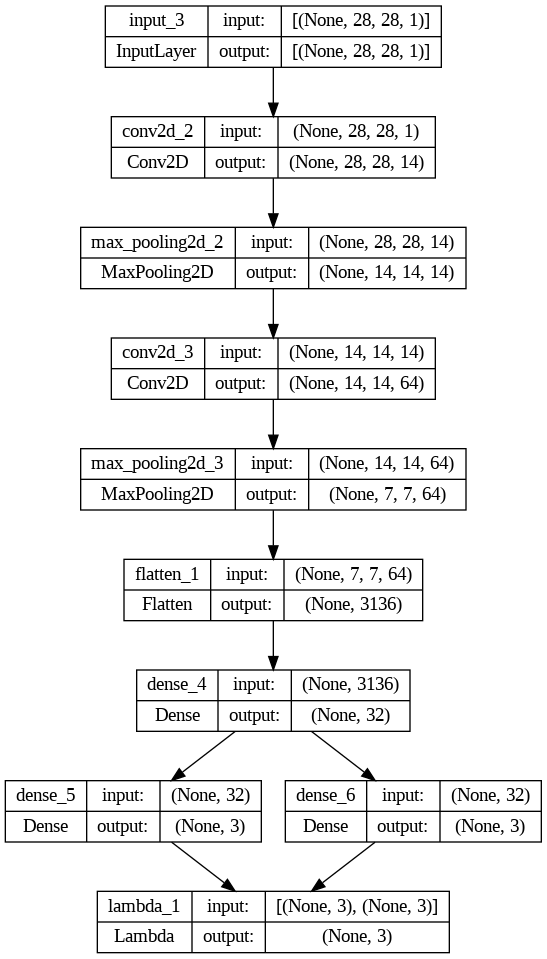

In [41]:
keras.utils.plot_model(encoder, show_shapes=True)

In [42]:
# decoder part

decoder_input = Input(shape=(latent_dims,))
x = layers.Dense(conv_shape[1] * conv_shape[2] * conv_shape[3])(decoder_input)
x = layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)

x = layers.Conv2DTranspose(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2DTranspose(14, 3, padding='same', activation='relu', strides=(2, 2))(x)
output = layers.Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, output)

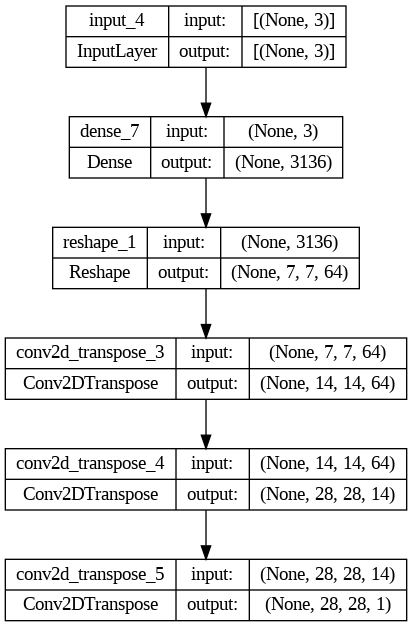

In [43]:
keras.utils.plot_model(decoder, show_shapes=True)

In [44]:
z_decoded = decoder(z)

In [45]:
class LossLayer(keras.layers.Layer):
  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
    return K.mean(recon_loss + kl_loss)

  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    return x

In [46]:
y = LossLayer()([image_input, z_decoded])

In [47]:
vae = Model(image_input, y)

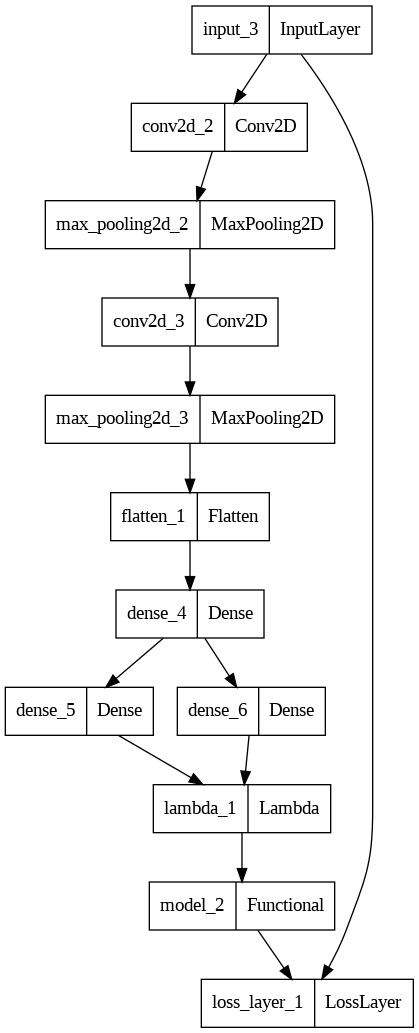

In [48]:
keras.utils.plot_model(vae)

In [49]:
vae.compile(
    optimizer='adam',
    loss=None
)

In [50]:
hist = vae.fit(
    X_train, None,
    batch_size=64,
    epochs=15,
    verbose=2,
    validation_split=0.2
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


48000/48000 - 10s - loss: 0.3647 - val_loss: 0.3302 - 10s/epoch - 218us/sample
Epoch 2/15
48000/48000 - 3s - loss: 0.3249 - val_loss: 0.3234 - 3s/epoch - 69us/sample
Epoch 3/15
48000/48000 - 3s - loss: 0.3206 - val_loss: 0.3222 - 3s/epoch - 70us/sample
Epoch 4/15
48000/48000 - 4s - loss: 0.3184 - val_loss: 0.3193 - 4s/epoch - 78us/sample
Epoch 5/15
48000/48000 - 3s - loss: 0.3169 - val_loss: 0.3181 - 3s/epoch - 69us/sample
Epoch 6/15
48000/48000 - 3s - loss: 0.3158 - val_loss: 0.3171 - 3s/epoch - 70us/sample
Epoch 7/15
48000/48000 - 4s - loss: 0.3150 - val_loss: 0.3168 - 4s/epoch - 75us/sample
Epoch 8/15
48000/48000 - 3s - loss: 0.3142 - val_loss: 0.3160 - 3s/epoch - 72us/sample
Epoch 9/15
48000/48000 - 3s - loss: 0.3136 - val_loss: 0.3152 - 3s/epoch - 69us/sample
Epoch 10/15
48000/48000 - 3s - loss: 0.3131 - val_loss: 0.3141 - 3s/epoch - 69us/sample
Epoch 11/15
48000/48000 - 4s - loss: 0.3125 - val_loss: 0.3142 - 4s/epoch - 78us/sample
Epoch 12/15
48000/48000 - 3s - loss: 0.3122 - val

In [51]:
vae.evaluate(X_test)

0.31411427249908447

In [52]:
pred = vae.predict(X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


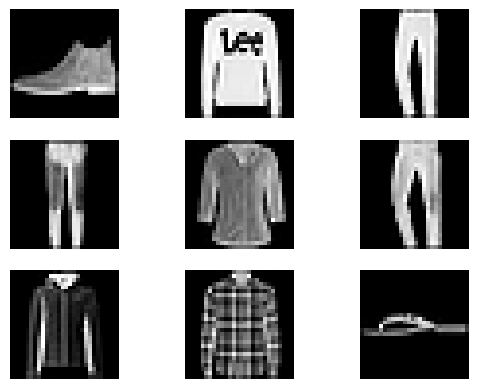

In [56]:
for i in range(9):
  plt.subplot(3, 3, i + 1)
  plt.axis('off')
  plt.imshow(pred[i], cmap='gray');

DAAAAAAAAAAAAAAAAAAAAAAAAAAAAMN <br>
So cool!!!

Ok. Now about the paper:<br>
Here's the <a href='https://drive.google.com/file/d/1IwGCEAaagWXfIXa98kvzHON01EMsn3K1/view?usp=sharing'>link</a><br>
I made it in <a href='https://miro.com/'>Miro</a><br>
If you are aware of virus - you can scan it with <a href='https://www.virustotal.com/gui/home/upload'>VirusTotal</a><br>

I'm a bad coder who doesn't write docs and uploads shitty code<br>
<img src='https://media.tenor.com/jyJYMgUHercAAAAi/thedeep.gif'>